In [1]:
import elephant
import neo
import quantities as pq
import numpy as np
from exana.stimulus import baysian_latency, generate_salt_trials
from exana.misc import concatenate_spiketrains
from elephant.spike_train_generation import homogeneous_poisson_process as hpp

%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
figsize(11, 9)

In [57]:
N_trials = 100
stim_duration = 100 * pq.ms
stim_start = 1000 * pq.ms
stim_latency = 50 * pq.ms
trial_duration = stim_duration + stim_start# + stim_latency
trains = []
stim_onsets = []
for n in range(N_trials):
    offset = trial_duration * n
    stim_onsets.append(offset)
    trains.extend([hpp(rate=2 * pq.Hz,
                      t_start=offset,
                      t_stop=stim_start + stim_latency + offset),
                  hpp(rate=0.1 * pq.Hz,
                      t_start=stim_start + stim_latency + offset,
                      t_stop=stim_start + stim_duration + offset)])
spike_train = concatenate_spiketrains(trains)

epoch = neo.Epoch(
    times=np.array(stim_onsets) * pq.ms,
    durations=np.array([trial_duration] * len(stim_onsets)) * pq.ms)


from exana.stimulus import make_spiketrain_trials
trials = make_spiketrain_trials(spike_train=spike_train, epoch=epoch)
from elephant.statistics import time_histogram
t_start = trials[0].t_start.rescale('s')
t_stop = trials[0].t_stop.rescale('s')

binsize = (abs(t_start)+abs(t_stop))/float(100)
time_hist = time_histogram(trials, binsize, t_start=t_start,
                           t_stop=t_stop, output='counts', binary=False)
bins = np.arange(t_start.magnitude, t_stop.magnitude, binsize.magnitude)

count_data = np.array([int(d) for d in time_hist.magnitude])

c:\apps\expipe-dev\exana\exana\misc\tools.py:69: UserWarning: Spiketrains have different stop times, we choose the largest
  ' largest')
c:\apps\expipe-dev\exana\exana\misc\tools.py:73: UserWarning: Spiketrains have different start times, we choose the smallest
  ' smallest')


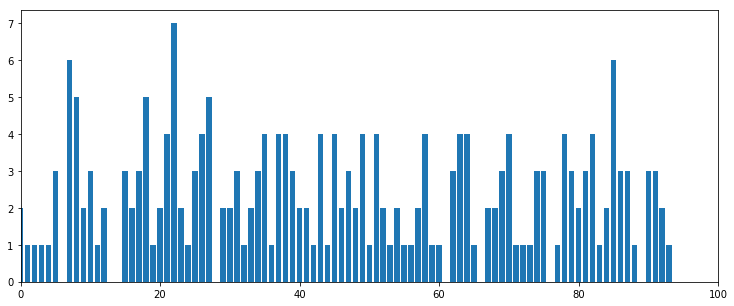

In [58]:
plt.figure()
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data)
plt.xlim(0, n_count_data);

In [59]:
import pymc3 as pm
import theano.tensor as tt

n_count_data = len(count_data)
with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)

    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)
    observation = pm.Poisson("obs", lambda_, observed=count_data)
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4014.45it/s]


In [60]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

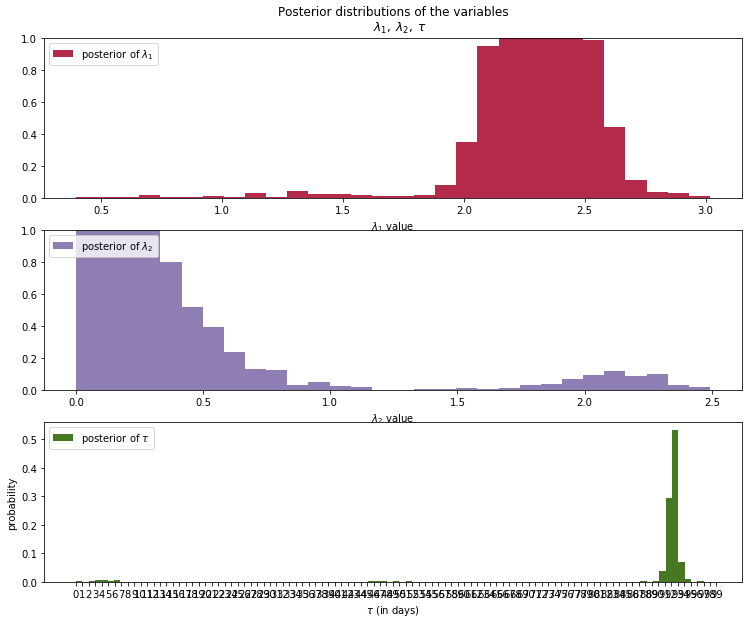

In [61]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
# plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
# plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
# plt.ylim([0, .75])
# plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

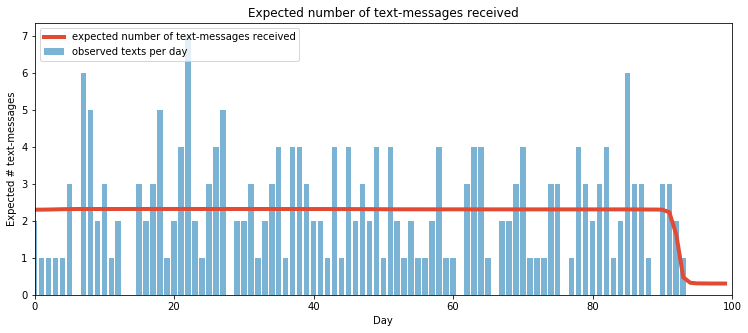

In [62]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
# plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");